# **Mounting the google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/CMPT340")

In [ ]:
!mkdir -p "/content/data"  # Create a data directory in a writable location
!cp "/content/gdrive/MyDrive/Colab Notebooks/CMPT340/data/archive.zip" "/content/data/"  # Copy the zip file to the new data directory
!unzip "/content/data/archive.zip" -d "/content/data/"  # Unzip the file in the new data directory

# **What are .nii files?**
NII format is created by Neuroimaging Informatics Technology Initiative. It is commonly used to store magnetic resonance imaging (MRI) data.

This sections of the code is just to see how to open and visualize this .nii data in python.

In [ ]:
import nibabel as nib
from glob import glob
import matplotlib.pylab as plt
import os

In [ ]:
ls

data/  gdrive/  img/  sample_data/


In [ ]:
def visualize_nii_files(base_directory, num_directories, slice_index, plane):
    """
    Visualize a specific slice from .nii files in different directories.

    Parameters:
    base_directory (str): The base path to the directory containing .nii files.
    num_directories (int): The number of directories to visualize one .nii file from.
    slice_index (int): The index of the slice to visualize from each .nii file.
    plane (int): The type of plane you want to visualize.
    """
    # Find all .nii files in the directory and subdirectories
    nii_files = sorted(glob(os.path.join(base_directory, '**/*.nii'), recursive=True))

    # Keep track of the directories we have already visualized to not end up getting the same file again
    visualized_directories = set()

    for file_path in nii_files:
        # Extract the directory of the current file
        current_directory = os.path.dirname(file_path)

        # If we have not visualized this directory yet
        if current_directory not in visualized_directories:
            # Load the image
            img = nib.load(file_path).get_fdata()

            # Check if the specified slice_index is within the range of the image's slices
            if slice_index < img.shape[2]:
                # Plot the specified slice
                plt.figure(figsize=(5, 5))
                # Axial slice
                if plane == 0:
                  plt.imshow(img[:, :, slice_index], cmap='gray')
                # Sagittal slices
                elif plane == 1:
                  plt.imshow(img[:, slice_index, :], cmap='gray')
                # Coronal slices
                elif plane == 2:
                  plt.imshow(img[slice_index, :, :], cmap='gray')
                else:
                  print("Plane doesent exits")
                plt.title(f'Slice {slice_index} of {os.path.basename(file_path)}')
                plt.axis('off')
                plt.show()

                # Add the directory to the set of visualized directories
                visualized_directories.add(current_directory)

                # If we have visualized the desired number of directories, break
                if len(visualized_directories) >= num_directories:
                    break
            else:
                print(f"Slice index {slice_index} is out of bounds for image {os.path.basename(file_path)} with shape {img.shape}")


# **Axial slice**

In [ ]:
# Call the function with the path to your .nii files
visualize_nii_files('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', num_directories=1, slice_index=75, plane = 0)

# **Sagittal slices**

In [ ]:
# Call the function with the path to your .nii files
visualize_nii_files('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', num_directories=1, slice_index=100, plane = 1)

# **Coronal slices**

In [ ]:
# Call the function with the path to your .nii files
visualize_nii_files('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', num_directories=1, slice_index=100, plane = 2)

# **Results of the Visualizer.**

These results show the images of a random slice of the training dataset on different planes.

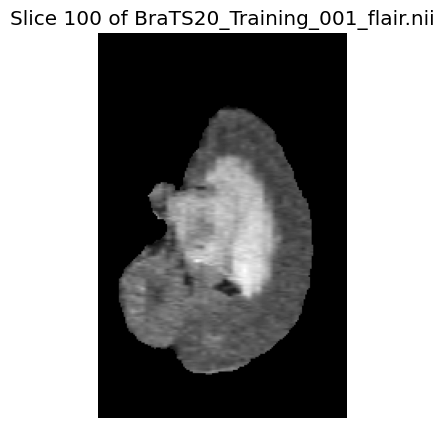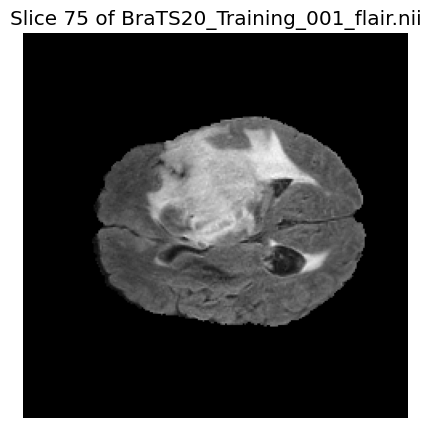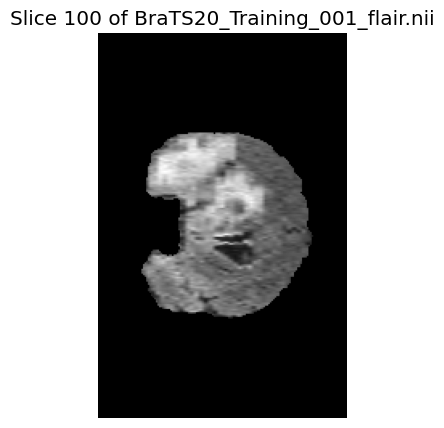

# **Regional Brain Tumor Detection**
### **Neural Network Dev**

Index:


*   Importing Libraries
*   Setting up constants for a neural network training task
*   Add all the training data directories to a variable
*   Creating train_ids
*   Splitting validation set to val_ids and test_ids





### **Importing all the important libraries used for this model**

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
!pip install nilearn
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
# !pip install git+https://github.com/tasfia1/gif_your_nifti.git
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

Setting up constants for a neural network training task

In [ ]:
# There are 155 slices per volume
# We want to use all 155 slices, start at 0 and end at 154
imgSize = 128
numSlices = 155
startingSlice = 0  # starting from the first slice of the volume
trainingSetDir='/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
validationSetDir = '/content/data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

Add all the training data directories for example BraTS20_Training_001 to BraTS20_Training_369





In [ ]:
'''
This is a list comprehension that goes through each entry in the directory.
For each entry, it checks if the entry is a directory (if f.is_dir()).
If the entry is a directory, it gets the path to the directory (f.path) and adds it to the list.
'''
train_and_val_directories = [f.path for f in os.scandir(trainingSetDir) if f.is_dir()]


# **Creating train_ids**

In [ ]:
# This is done because the mask file in the data for file BraTS20_Training_335 seems to have bad data
# Removing it is a better idea than renaming it as the data could be courpted.
train_and_val_directories.remove('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_335')

In [ ]:
#
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

In [ ]:
train_and_test_ids = pathListIntoIds(train_and_val_directories);

In [ ]:
print(train_and_test_ids)

['BraTS20_Training_136', 'BraTS20_Training_263', 'BraTS20_Training_164', 'BraTS20_Training_280', 'BraTS20_Training_199', 'BraTS20_Training_341', 'BraTS20_Training_292', 'BraTS20_Training_197', 'BraTS20_Training_028', 'BraTS20_Training_047', 'BraTS20_Training_210', 'BraTS20_Training_061', 'BraTS20_Training_160', 'BraTS20_Training_037', 'BraTS20_Training_315', 'BraTS20_Training_095', 'BraTS20_Training_147', 'BraTS20_Training_346', 'BraTS20_Training_098', 'BraTS20_Training_029', 'BraTS20_Training_311', 'BraTS20_Training_368', 'BraTS20_Training_171', 'BraTS20_Training_252', 'BraTS20_Training_344', 'BraTS20_Training_038', 'BraTS20_Training_193', 'BraTS20_Training_209', 'BraTS20_Training_319', 'BraTS20_Training_170', 'BraTS20_Training_156', 'BraTS20_Training_075', 'BraTS20_Training_294', 'BraTS20_Training_250', 'BraTS20_Training_192', 'BraTS20_Training_191', 'BraTS20_Training_267', 'BraTS20_Training_215', 'BraTS20_Training_262', 'BraTS20_Training_337', 'BraTS20_Training_094', 'BraTS20_Traini

In [ ]:
# Sorted the directories for consistant and ease of understanding.
train_ids = sorted(train_and_test_ids)
print(train_ids)

['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010', 'BraTS20_Training_011', 'BraTS20_Training_012', 'BraTS20_Training_013', 'BraTS20_Training_014', 'BraTS20_Training_015', 'BraTS20_Training_016', 'BraTS20_Training_017', 'BraTS20_Training_018', 'BraTS20_Training_019', 'BraTS20_Training_020', 'BraTS20_Training_021', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_024', 'BraTS20_Training_025', 'BraTS20_Training_026', 'BraTS20_Training_027', 'BraTS20_Training_028', 'BraTS20_Training_029', 'BraTS20_Training_030', 'BraTS20_Training_031', 'BraTS20_Training_032', 'BraTS20_Training_033', 'BraTS20_Training_034', 'BraTS20_Training_035', 'BraTS20_Training_036', 'BraTS20_Training_037', 'BraTS20_Training_038', 'BraTS20_Training_039', 'BraTS20_Training_040', 'BraTS20_Training_041', 'BraTS20_Traini

# **Splitting validation set to val_ids and test_ids**

In [ ]:
validation_directories = [f.path for f in os.scandir(validationSetDir) if f.is_dir()]

In [ ]:
# Get the IDs from the validation directories
validation_ids = pathListIntoIds(validation_directories)

In [ ]:
sorted_validation_ids = sorted(validation_ids)

In [ ]:
# Split the validation set into validation and test sets
# 80% of the data will be used for validation, 20% for test
val_ids, test_ids = train_test_split(sorted_validation_ids, test_size=0.4)

In [ ]:
print("Size of training set:", len(train_ids))
print("Size of validation set:", len(val_ids), val_ids)
print("Size of test set:", len(test_ids))

Size of training set: 368
Size of validation set: 75 ['BraTS20_Validation_103', 'BraTS20_Validation_104', 'BraTS20_Validation_028', 'BraTS20_Validation_045', 'BraTS20_Validation_123', 'BraTS20_Validation_033', 'BraTS20_Validation_073', 'BraTS20_Validation_120', 'BraTS20_Validation_024', 'BraTS20_Validation_031', 'BraTS20_Validation_005', 'BraTS20_Validation_058', 'BraTS20_Validation_053', 'BraTS20_Validation_061', 'BraTS20_Validation_082', 'BraTS20_Validation_122', 'BraTS20_Validation_114', 'BraTS20_Validation_102', 'BraTS20_Validation_052', 'BraTS20_Validation_091', 'BraTS20_Validation_059', 'BraTS20_Validation_042', 'BraTS20_Validation_060', 'BraTS20_Validation_017', 'BraTS20_Validation_070', 'BraTS20_Validation_086', 'BraTS20_Validation_072', 'BraTS20_Validation_087', 'BraTS20_Validation_108', 'BraTS20_Validation_093', 'BraTS20_Validation_020', 'BraTS20_Validation_119', 'BraTS20_Validation_117', 'BraTS20_Validation_046', 'BraTS20_Validation_105', 'BraTS20_Validation_064', 'BraTS20_V

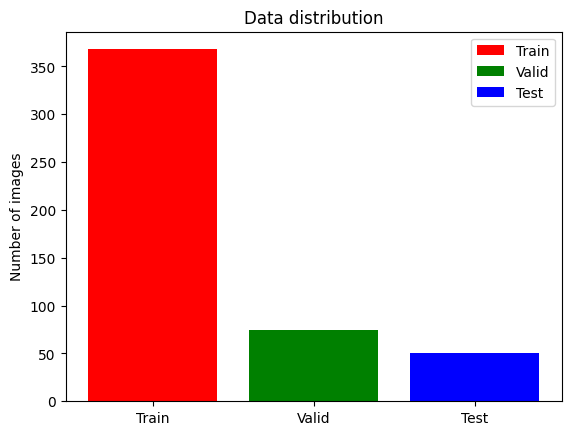

In [ ]:
def showDataLayout():
    # Create a bar chart with labels
    plt.bar(["Train","Valid","Test"],
            [len(train_ids), len(val_ids), len(test_ids)],
            align='center',
            color=['red', 'green', 'blue'],
            label=['Train', 'Valid', 'Test'])  # Add labels here

    # Call plt.legend() to display the legend
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()


In [ ]:
import numpy as np
import nibabel as nib
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Assuming these constants are defined in your script as per your previous messages
IMG_SIZE = 128
VOLUME_SLICES = 155  # Updated to use all slices
VOLUME_START_AT = 0  # Start at the first slice
TRAIN_DATASET_PATH = '/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, base_path, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.base_path = base_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(batch_ids)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)

        # Generate data
        for c, id_ in enumerate(batch_ids):
            case_path = os.path.join(self.base_path, id_)

            # Load the images
            flair_path = os.path.join(case_path, f'{id_}_flair.nii')
            t1ce_path = os.path.join(case_path, f'{id_}_t1ce.nii')
            seg_path = os.path.join(case_path, f'{id_}_seg.nii')

            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                seg_slice = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_NEAREST)

                # One-hot encode the segmentation labels
                Y[j + VOLUME_SLICES * c] = tf.one_hot(seg_slice.astype(np.int32), 4)

        # Normalize the images
        X = X / np.max(X)
        return X, Y

# Instantiate the data generators
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH)
valid_generator = DataGenerator(val_ids, validationSetDir)
test_generator = DataGenerator(test_ids, validationSetDir)


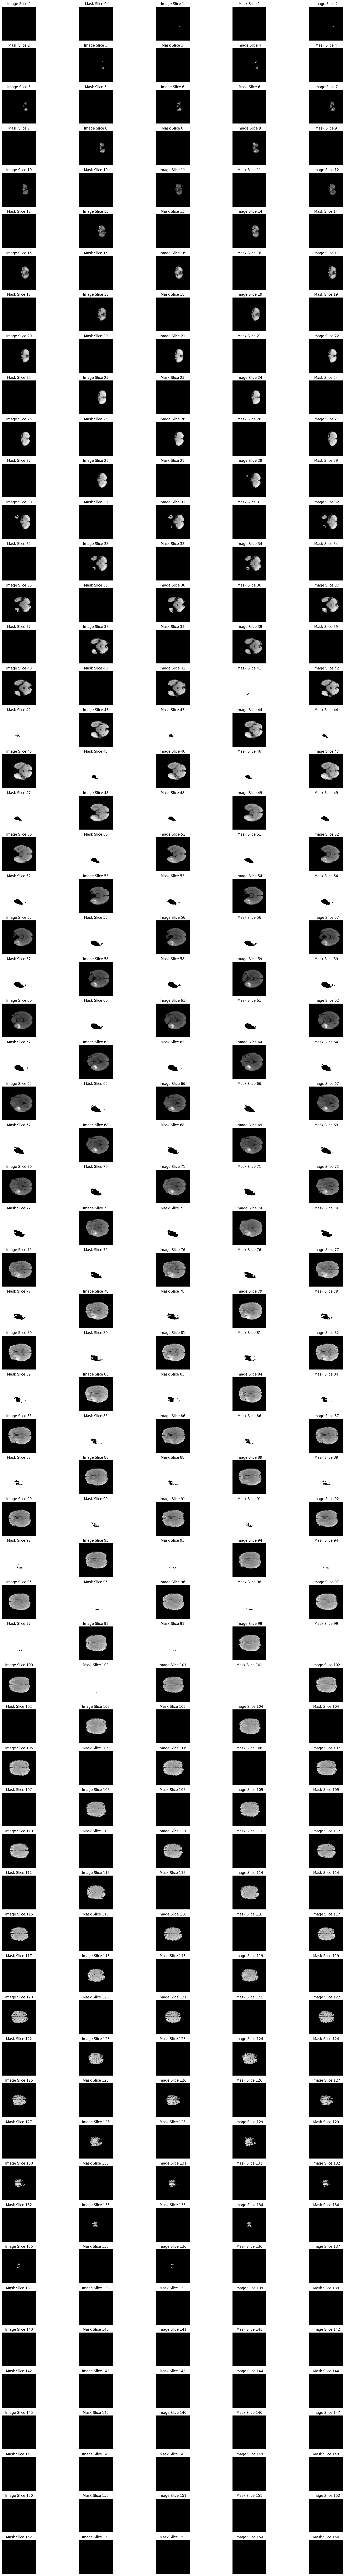

In [ ]:
# Assuming data_batch is a tuple containing (X, y) returned from the DataGenerator
data_batch = training_generator.__getitem__(0)

# Get the input data (X) and the masks (y)
X = data_batch[0]
y = data_batch[1]

# Set the number of slices per row
slices_per_row = 5

# Calculate the total number of rows needed for images and masks
num_rows = (X.shape[0] + slices_per_row - 1) // slices_per_row

# Create a figure with subplots for images and masks
fig, axes = plt.subplots(num_rows * 2, slices_per_row, figsize=(20, num_rows * 4))  # times 2 for images and masks

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each slice and display it in a subplot along with the corresponding mask
for i in range(X.shape[0]):
    # Display the image slice
    axes[i * 2].imshow(X[i, :, :, 0], cmap='gray')  # Change 0 to 1 if you want to display the second channel
    axes[i * 2].set_title(f'Image Slice {i}')
    axes[i * 2].axis('off')

    # Display the corresponding mask slice
    # Assuming the mask has one channel; if it has more, you need to adjust the indexing
    axes[i * 2 + 1].imshow(y[i, :, :, 0], cmap='gray')  # Adjust the index if your mask has multiple channels
    axes[i * 2 + 1].set_title(f'Mask Slice {i}')
    axes[i * 2 + 1].axis('off')

# Hide any remaining axes if there are fewer images than subplots
for j in range(i * 2 + 2, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Loss function
Dice loss function and the combined Binary Cross-Entropy (BCE) with Dice loss

In [ ]:
import tensorflow.keras.backend as K

# calculates the Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)

# computes the Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# combines Binary Cross-Entropy loss with Dice loss
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)


# Convolution
U-Net

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def conv_block(input_tensor, num_filters):
    """Builds the conv block for the U-Net."""
    tensor = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    tensor = BatchNormalization()(tensor)
    tensor = Activation('relu')(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same')(tensor)
    tensor = BatchNormalization()(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def encoder_block(input_tensor, num_filters):
    """Builds the encoder block for the U-Net."""
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Builds the decoder block for the U-Net."""
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([decoder, concat_tensor], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    return decoder

def unet(input_size=(128, 128, 1), num_classes=1):
    """Builds the U-Net model."""
    inputs = Input(input_size)

    # Downsampling through the model
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

    # Bottleneck
    center = conv_block(encoder4_pool, 1024)

    # Upsampling through the model
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder0)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create a U-Net model
unet_model = unet(input_size=(128, 128, 1), num_classes=1)

# Compile the model
unet_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])

# Display the model summary
unet_model.summary()
